In [5]:
import os
import numpy as np
import scipy.io
import tensorflow as tf
import tarfile
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Define the URLs for the dataset files
flowers_url = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz"
labels_url  = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat"
setid_url   = "http://www.robots.ox.ac.uk/~vgg/data/flowers/102/setid.mat"

# Download the files using tf.keras.utils.get_file
flowers_path = tf.keras.utils.get_file("102flowers.tgz", origin=flowers_url)
labels_path  = tf.keras.utils.get_file("imagelabels.mat", origin=labels_url)
setid_path   = tf.keras.utils.get_file("setid.mat", origin=setid_url)

# Extract the flower images archive (images will be stored in a folder named "jpg")
if not os.path.exists("jpg"):
    with tarfile.open(flowers_path, "r:gz") as tar:
        tar.extractall(path=".")

# Load labels (each label corresponds to an image, in order)
labels_mat = scipy.io.loadmat(labels_path)
labels = labels_mat['labels'][0]  # shape: (N,)

# Load the datasplits from setid.mat
setid = scipy.io.loadmat(setid_path)
train_ids = setid['trnid'][0]   # training indices
val_ids   = setid['valid'][0]   # validation indices
test_ids  = setid['tstid'][0]   # test indices

# Helper function to build image file paths (images are in the "jpg" folder)
def get_filename(i):
    return os.path.join('jpg', 'image_{:05d}.jpg'.format(i))

# Create lists of filenames and corresponding labels.
# Note: image indices in the .mat files are 1-indexed.
all_filenames = [get_filename(i) for i in range(1, len(labels) + 1)]
all_labels = labels

# Build split lists. Also convert labels from 1-indexed to 0-indexed.
train_files = [all_filenames[i-1] for i in train_ids]
train_labels = [all_labels[i-1] - 1 for i in train_ids]

val_files = [all_filenames[i-1] for i in val_ids]
val_labels = [all_labels[i-1] - 1 for i in val_ids]

test_files = [all_filenames[i-1] for i in test_ids]
test_labels = [all_labels[i-1] - 1 for i in test_ids]

print("Training samples:", len(train_files))
print("Validation samples:", len(val_files))
print("Test samples:", len(test_files))


Training samples: 1020
Validation samples: 1020
Test samples: 6149


In [6]:
IMG_SIZE = 224
BATCH_SIZE = 32

def preprocess_image(image_path, label):
    # Read and decode the JPEG image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize image to match ResNet50 expected input size
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    # Preprocess using the ResNet50 preprocessing function
    image = tf.keras.applications.resnet50.preprocess_input(image)
    return image, label

# Create TensorFlow datasets for training, validation, and testing
train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

val_ds = tf.data.Dataset.from_tensor_slices((val_files, val_labels))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)


In [7]:
WEIGHT_DECAY = 1e-4  # L2 regularization factor
DROPOUT_RATE = 0.5  # Dropout rate

# Data Augmentation Layer
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(), 
    tf.keras.layers.RandomRotation(0.2)
])

# Load the pre-trained ResNet50 base model without the top classification layer
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
base_model.trainable = False  # Freeze the base model for initial training to make the model run faster

# Build the complete model
inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)  # Apply data augmentation
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(DROPOUT_RATE)(x)  # Dropout for regularization
outputs = tf.keras.layers.Dense(102, activation='softmax', 
                                kernel_regularizer=tf.keras.regularizers.l2(WEIGHT_DECAY))(x)  # L2 weight decay

model = tf.keras.Model(inputs, outputs)

# Use Adam with weight decay
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, weight_decay=WEIGHT_DECAY)

model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_1 (Sequential)            │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 102)                 │         208,998 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 23,796,710 (90.78 MB)

 Trainable params: 208,998 (816.40 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [8]:
#Training the model for 15 epochs and storing the data
epochs = 15
history = model.fit(
    train_ds,
    epochs=epochs,
    validation_data=val_ds
)

Epoch 1/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 134s 4s/step - accuracy: 0.0384 - loss: 5.5153 - val_accuracy: 0.2618 - val_loss: 3.2764
Epoch 2/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 74s 2s/step - accuracy: 0.2082 - loss: 3.2524 - val_accuracy: 0.6000 - val_loss: 2.0121
Epoch 3/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 130s 4s/step - accuracy: 0.5094 - loss: 2.0408 - val_accuracy: 0.6892 - val_loss: 1.5054
Epoch 4/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 180s 5s/step - accuracy: 0.6212 - loss: 1.5440 - val_accuracy: 0.7451 - val_loss: 1.2368
Epoch 5/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 172s 5s/step - accuracy: 0.7197 - loss: 1.1067 - val_accuracy: 0.7637 - val_loss: 1.0880
Epoch 6/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 240s 8s/step - accuracy: 0.7938 - loss: 0.9347 - val_accuracy: 0.7980 - val_loss: 0.9757
Epoch 7/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 238s 7s/step - accuracy: 0.8473 - loss: 0.7507 - val_accuracy: 0.8108 - val_loss: 0.9032
Epoch 8/15
32/32 ━━━━━━━━━━━━━━━━━━━━ 161s 4s/step - accuracy: 0.8768 - loss: 0.6302 - val_accuracy: 0.8245 - va

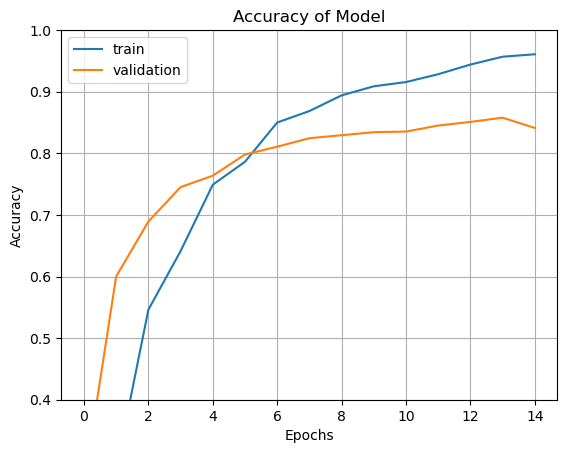

In [9]:
#Create a plot of training and validation accuracy accross the epochs
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.axis(ymin=0.4,ymax=1)
plt.grid()
plt.title('Accuracy of Model')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [10]:
from sklearn.metrics import f1_score
import numpy as np

# Get model predictions
y_pred_probs = model.predict(test_ds)  # Get predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class labels

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)  # Extract labels from dataset

# Compute F1 score
f1 = f1_score(y_true, y_pred, average="weighted")  # Use "weighted" for imbalanced classes
print(f"F1 Score: {f1:.4f}")


193/193 ━━━━━━━━━━━━━━━━━━━━ 363s 2s/step
F1 Score: 0.8111


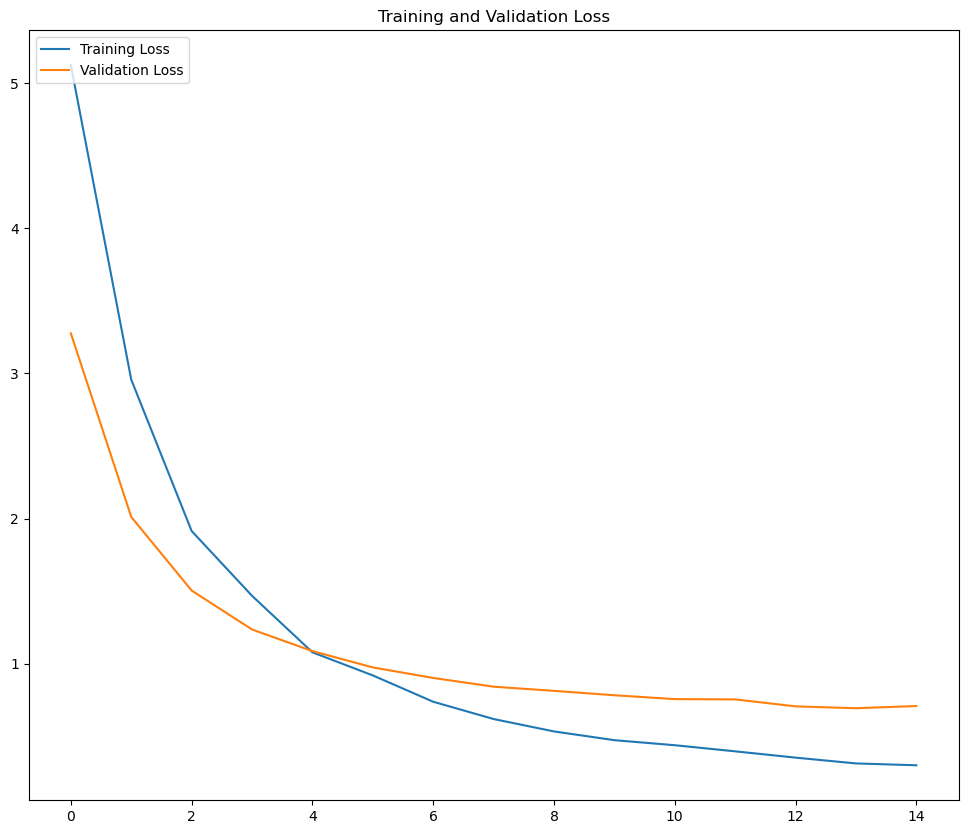

In [11]:
train_loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 10))
plt.plot(epochs_range, train_loss, label="Training Loss")
plt.plot(epochs_range, val_loss, label="Validation Loss")
plt.legend(loc='upper left')
plt.title('Training and Validation Loss')

plt.show()